# Time series challenge

## Theorethical questions

### 1. Name two advantages and two disadvantages of using LSTM over ARIMA for time series forecasting

**Advantages**:

- multivariate approach; take advantage of non-linear relations. 

- better capture of long term information. 

**Disadvantages**: 

- Interpretability; LSTM, as most deep learning approaches, is not suitable for explainability. 
- Computational power; ARIMA is much cheaper to train. 

### 2. Why is standard k-fold cross-validation not suitable for time series data? What technique would you recommend instead?

Time series is data of historic events, whose records contain temporal dependency between consecutive samples. Therefore, it must be presented, processed and analysed in its chronological progression. We have to consider the temporal precedence to split the data.

The second reason is that, if you apply standard k-fol cross-validation, you could end up training on future data and evaluating on past data. 

To divide the dataset, a common approach is to divide considering the chronological order, for example, first 70% for training, next 20% for testing and the last 10% for validation. But not mixing the splits like in traditional machine learning. 

Another option is to use a Time Series Split, which creates samples equally spaced where each test set covers the same time duration, while the train set size accumulates data from previous splits. For example, in the k-th split, it returns the first k-folds as the train set and the (k+1)-th fold as the test size. 


## Case study

Based on the Ventas_.csv file, the task is forecast monthly demand.

### Cleaning and preparing the dataset

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [ ]:
df = pd.read_csv('Ventas_.csv')
df

The dataset has three variables: 
- Fecha, which is object type and should be casted into a date type column or a datetime index. 
- Estado, another string which could be casted into a categorical (or 'factor') datatype. 
- Ventas, a numeric variable which is loaded as a floating variable. 

In [ ]:
df.info()

In [ ]:
# Casting variables: 
df['Fecha'] = pd.to_datetime(df['Fecha'])
df['Estado'] = df['Estado'].astype('category')
df.dtypes # Now we have the 'Fecha' and 'Estado' variables with the proper codification. 

There's no missing data:

In [ ]:
df.isnull().sum()

### Exploratory data analysis


#### Fechas

In [ ]:
print(f"Registro más antiguo: {df['Fecha'].min()}")
      
print(f"Registro más reciente:{df['Fecha'].max()}")

In [ ]:
df['año'] = df['Fecha'].dt.year 
df['mes'] = df['Fecha'].dt.month

year_summary = df.groupby('año')['Ventas'].describe()
year_summary['total_ventas'] =  df.groupby('año')['Ventas'].agg('sum')
print("Total sales per year")
year_summary['total_ventas']

In [ ]:
sns.barplot(year_summary, x = 'año', y = 'total_ventas', hue='año', order=['2023', '2024', '2025'], legend=False) 
plt.ticklabel_format(style='plain', axis='y')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar por año
year_2023 = df[df['año'] == 2023]
ventas_2023 = year_2023.groupby('mes')['Ventas'].sum().reset_index()

year_2024 = df[df['año'] == 2024]
ventas_2024 = year_2024.groupby('mes')['Ventas'].sum().reset_index()

year_2025 = df[df['año'] == 2025]
ventas_2025 = year_2025.groupby('mes')['Ventas'].sum().reset_index()

# Crear figura con 3 subplots en una columna
fig, axes = plt.subplots(3, 1, figsize=(12,12), sharey=True)

# 2023
sns.barplot(data=ventas_2023, x='mes', y='Ventas', estimator='sum', errorbar=None, ax=axes[0], hue='mes', legend= False, palette="Greens_d")
axes[0].set_title("Ventas mensuales en 2023", fontsize=14)
axes[0].set_xlabel("Mes")
axes[0].set_ylabel("Total de ventas")

# 2024
sns.barplot(data=ventas_2024, x='mes', y='Ventas', estimator='sum', errorbar=None, ax=axes[1],hue='mes', legend= False, palette="Blues_d")
axes[1].set_title("Ventas mensuales en 2024", fontsize=14)
axes[1].set_xlabel("Mes")
axes[1].set_ylabel("Total de ventas")

# 2025
sns.barplot(data=ventas_2025, x='mes', y='Ventas', estimator='sum', errorbar=None, ax=axes[2], hue='mes', legend= False, palette="Oranges_d")
axes[2].set_title("Ventas mensuales en 2025", fontsize=14)
axes[2].set_xlabel("Mes")
axes[2].set_ylabel("Total de ventas")

# Ajustar espacios
plt.tight_layout()
plt.show()


#### Estado

In [ ]:
print(f"Number of different states in the dataset: {len(list(df['Estado'].unique()))}")
list(df['Estado'].unique())


In [ ]:
ventas_estado = df.groupby("Estado", observed=True)["Ventas"].sum().reset_index()
print('Representativeness of states; ten states with less sales:')
ventas_estado.sort_values('Ventas').head(10).round(2)

In [ ]:
print('Representativeness of states; ten states with more sales:')
ventas_estado.sort_values('Ventas', ascending=False).head(10).round(2)

In [ ]:

plt.figure(figsize=(8, 9)) 
sns.barplot(ventas_estado,
             x='Ventas',
             y = 'Estado',
             order= list(ventas_estado.sort_values('Ventas')['Estado']),
             errorbar=None             
             )

#### Ventas

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.lineplot(data=df, x="Fecha", y="Ventas", marker="o")
plt.title("Temporal series (ungrouped)", fontsize=14)
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.show()


In [ ]:
# Group by month
df_monthly = df.groupby("Fecha")["Ventas"].sum().reset_index()

# Sort
df_monthly = df_monthly.sort_values("Fecha").reset_index(drop=True)

df_monthly.head()

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_monthly, x="Fecha", y="Ventas", marker="o")
plt.title("Temporal series (grouped by month)", fontsize=14)
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10,5))
plot_acf(df_monthly["Ventas"], lags=25) 
plt.title("Self correlation in sales", fontsize=14)
plt.show() # not strong evidence of seasonality, but maybe a ciclic pattern


### Choosing and validating forecasting models 

#### Movile average

Movile average was applied with two different window sizes.

In [ ]:
moving_average = df_monthly.copy()

moving_average["MA_3"] = df_monthly["Ventas"].rolling(window=3).mean()
moving_average["MA_6"] = df_monthly["Ventas"].rolling(window=6).mean()

# Graficar
plt.figure(figsize=(12,6))
plt.plot(moving_average["Fecha"], moving_average["Ventas"], label="Ventas reales", marker="o")
plt.plot(moving_average["Fecha"], moving_average["MA_3"], label="Media móvil 3  meses", linestyle="--")
plt.plot(moving_average["Fecha"], moving_average["MA_6"], label="Media móvil 6 meses", linestyle="--")

plt.title("Ventas mensuales y medias móviles", fontsize=14)
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Evaluation 
moving_average_eval = moving_average.copy()
moving_average_eval.dropna(subset=['MA_3', 'MA_6'], inplace=True) # drop NAs result of the computation of mean with the first registers


mae_3 = mean_absolute_error(moving_average_eval['Ventas'], moving_average_eval['MA_3'])
mae_6 = mean_absolute_error(moving_average_eval['Ventas'], moving_average_eval['MA_6'])

rmse_3 = np.sqrt(mean_squared_error(moving_average_eval['Ventas'], moving_average_eval['MA_3']))
                 
rmse_6 = np.sqrt(mean_squared_error(moving_average_eval['Ventas'], moving_average_eval['MA_6']))


mape_3 = np.mean(np.abs((moving_average_eval['Ventas'] - moving_average_eval['MA_3']) / moving_average_eval['Ventas'])) * 100
mape_6 = np.mean(np.abs((moving_average_eval['Ventas'] - moving_average_eval['MA_6']) / moving_average_eval['Ventas'])) * 100

print(f"MAE: 3 months: {mae_3:.2f} ; 6 months: {mae_6:.2f}")
print(f"RMSE: 3 months: {rmse_3:.2f}; 6 months: {rmse_6:.2f}")
print(f"MAPE: 3 months: {mape_3:.2f}% ; 6 months: {mape_6:.2f}")




#### Exponential smoothing


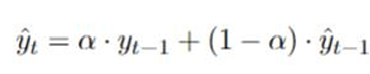


In [ ]:
from statsmodels.tsa.api import  SimpleExpSmoothing
df_ses = df_monthly.copy()


ses = SimpleExpSmoothing(df_monthly['Ventas'])

fit = ses.fit(optimized=True)

df_ses['SES'] = fit.fittedvalues 


df_ses.head()

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df_ses["Fecha"], df_ses["Ventas"], marker="o", label="Ventas reales")
plt.plot(df_ses["Fecha"], df_ses["SES"], linestyle="--", label="Suavizado exponencial (SES)")
plt.legend()
plt.title("Exponential smoothing")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.show()


In [ ]:
# Metrics

# Evaluation 
df_ses_eval = df_ses.copy()

mae_ses = mean_absolute_error(df_ses_eval['Ventas'], df_ses_eval['SES'])

rmse_ses = np.sqrt(mean_squared_error(df_ses_eval['Ventas'], df_ses_eval['SES']))
                 
mape_ses = np.mean(np.abs((df_ses_eval['Ventas'] - df_ses_eval['SES']) / df_ses_eval['Ventas'])) * 100

print(f"MAE: 3 months: {mae_ses:.2f}")
print(f"RMSE: 3 months: {rmse_ses:.2f}")
print(f"MAPE: 3 months: {mape_ses:.2f}")

#### Movile average and Exponential smoothing, final test

##### Movile average

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

df_final_ma = df_monthly.copy()

tscv = TimeSeriesSplit(n_splits=3) # three folds

mae_ma3, rmse_ma3 = [], []
mae_ma6, rmse_ma6 = [], []


n_steps = 5 # number of values to forecast and evaluate

for fold, (train_idx, test_idx) in enumerate(tscv.split(df_final_ma)):
    train, test = df_final_ma.iloc[train_idx], df_final_ma.iloc[test_idx]

    print(f"\nFold {fold+1}")
    print(f"Train: {len(train)} registros, Test: {len(test)} registros")

    y_train = train["Ventas"]
    y_test = test["Ventas"]
    steps = min(n_steps, len(y_test)) # choose the left part of the test array if is smaller than n_steps




    # --- Model 1: MA(3) iterative forecast  ---
    history = list(y_train)
    y_pred_ma3 = []

    for i in range(steps): 
        pred = np.mean(history[-3 : ])
        y_pred_ma3.append(pred)
        history.append(pred)

    mae_ma3.append(mean_absolute_error(y_test[:steps], y_pred_ma3))
    rmse_ma3.append(np.sqrt(mean_squared_error(y_test[:steps], y_pred_ma3)))




    # --- Model 2: MA(6) iterative forecast ---

    history = list(y_train)
    y_pred_ma6 = []
    for _ in range(steps):
        pred = np.mean(history[-6:])
        y_pred_ma6.append(pred)
        history.append(pred)
    mae_ma6.append(mean_absolute_error(y_test[:steps], y_pred_ma6))
    rmse_ma6.append(np.sqrt(mean_squared_error(y_test[:steps], y_pred_ma6)))


    # Graphic
    plt.figure(figsize=(10,4))
    plt.plot(train["Fecha"], y_train, label="Train")
    plt.plot(test["Fecha"][:steps], y_test[:steps], label="Test", marker="o")
    plt.plot(test["Fecha"][:steps], y_pred_ma3, label="MA (3) forecast", linestyle="--")
    plt.plot(test["Fecha"][:steps], y_pred_ma6, label="MA (6) forecast", linestyle="--")
    plt.legend()
    plt.title(f"Fold {fold+1} - Predicciones multi-step")
    plt.show()

# --- Results
print("\nMetrics:")
print(f"Movile average (3 meses): MAE={np.mean(mae_ma3):.2f}, RMSE={np.mean(rmse_ma3):.2f}")
print(f"Movile average (6 meses): MAE={np.mean(mae_ma6):.2f}, RMSE={np.mean(rmse_ma6):.2f}")



##### Exponential smoothing

In [ ]:
# Número de meses a predecir
n_test = 5

# Dividir la serie
y_train = df_monthly["Ventas"][:-n_test].values
y_test = df_monthly["Ventas"][-n_test:].values
fecha_test = df_monthly["Fecha"][-n_test:].values

# --- Modelo SES ---
ses_model = SimpleExpSmoothing(y_train).fit(optimized=True)
y_pred_ses = ses_model.forecast(n_test)

mae_ses = mean_absolute_error(y_test, y_pred_ses)
rmse_ses = np.sqrt(mean_squared_error(y_test, y_pred_ses))


fitted_values = ses_model.fittedvalues 

# --- Gráfica ---}

plt.figure(figsize=(12,5))
plt.plot(df_monthly["Fecha"][:-n_test], y_train, label="Train")
plt.plot(fecha_test, y_test, label="Test", marker="o")
plt.plot(fecha_test, y_pred_ses, label="SES forecast", linestyle="--")
plt.plot(df_monthly["Fecha"][:-n_test], fitted_values, linestyle="--", label="Suavizado exponencial (SES)")

plt.legend()
plt.title(f"Forecast últimos {n_test} meses")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.show()

# --- Resultados ---
print(f"SES: MAE={mae_ses:.2f}, RMSE={rmse_ses:.2f}")
print(f"Alfa SES: {ses_model.params['smoothing_level']:.2f}")






### Prediction of hypothetical next five months with the three methods

In [ ]:

n_steps = 5  # number of months to predict

# complete series
y = df_monthly["Ventas"].values
fechas = df_monthly["Fecha"]


last_date = fechas.iloc[-1] # last date of the original set 

future_dates = pd.date_range(start=last_date, periods=n_steps+1, freq="MS")[1:]

# ================================
# Modelo 1: MA(3) 
# ================================
history = list(y)
y_pred_ma3 = []
for _ in range(n_steps):
    pred = np.mean(history[-3:])
    y_pred_ma3.append(pred)
    history.append(pred)

# ================================
# Modelo 2: MA(6) 
# ================================
history = list(y)
y_pred_ma6 = []
for _ in range(n_steps):
    pred = np.mean(history[-6:])
    y_pred_ma6.append(pred)
    history.append(pred)

# ================================
# Modelo 3: SES forecast
# ================================
ses_model = SimpleExpSmoothing(y).fit(optimized=True)
y_pred_ses = ses_model.forecast(n_steps)

# ================================
# DataFrame with results
# ================================
forecast_df = pd.DataFrame({
    "Fecha": future_dates,
    "MA(3)": y_pred_ma3,
    "MA(6)": y_pred_ma6,
    "SES": y_pred_ses
})

forecast_df = forecast_df.round(0)

print(forecast_df)

# ================================
# Graphics
# ================================
plt.figure(figsize=(12,6))
plt.plot(fechas, y, label="Histórico", marker="o")

plt.plot(future_dates, y_pred_ma3, label="MA(3) Forecast", linestyle="--", marker="o")
plt.plot(future_dates, y_pred_ma6, label="MA(6) Forecast", linestyle="--", marker="o")
plt.plot(future_dates, y_pred_ses, label="SES Forecast", linestyle="-.", marker="o")

plt.axvline(x=last_date, color="gray", linestyle=":")  # línea para separar train vs forecast
plt.legend()
plt.title("Predicción de los próximos 5 meses con MA y SES")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.show()


## Part 2: a supervised approach with random forest

### Model 1: forecasting *total* sales per month

In [ ]:
# Crear lags
def create_lags(df, n_lags=6):
    data = df.copy()
    for lag in range(1, n_lags+1):
        data[f"lag_{lag}"] = data["Ventas"].shift(lag)
    return data

# we use the dataframe grouped by month (and we lost the State column)

df_lags = create_lags(df_monthly, n_lags=6).dropna().reset_index(drop=True)

df_lags.head()

In [ ]:
### Version 2 de RF; añadiendo columna de mes 
df_rf2 = df_lags.copy()
df_rf2['month'] = df_rf2['Fecha'].dt.month 
df_rf2


from sklearn.model_selection import train_test_split

# Split train and test sets
df_train_2, df_test_2 = train_test_split(df_rf2, train_size=0.75, test_size=0.25, shuffle=False)
print("Train and Test size", len(df_train_2), "--", len(df_test_2))



X_train_2, y_train_2 = df_train_2.drop(columns=['Fecha', 'Ventas']), df_train_2['Ventas']
X_test_2, y_test_2 = df_test_2.drop(columns=['Fecha', 'Ventas']), df_test_2['Ventas']

##############################
from sklearn.ensemble import RandomForestRegressor

rf2 = RandomForestRegressor(n_estimators=200, random_state=42)
rf2.fit(X_train_2, y_train_2)

y_pred_2 = rf2.predict(X_test_2)


mae_2 = mean_absolute_error(y_test_2, y_pred_2)
rmse_2 = np.sqrt(mean_squared_error(y_test_2, y_pred_2))

print(f"Random Forest -> MAE: {mae_2:.2f}, RMSE: {rmse_2:.2f}")


plt.figure(figsize=(10,5))
plt.plot(df_train_2["Fecha"], y_train_2, label="Train")
plt.plot(df_test_2["Fecha"], y_test_2, label="Test", marker="o")
plt.plot(df_test_2["Fecha"], y_pred_2, label="RF Forecast", marker="x", linestyle="--")
plt.legend()
plt.title("Total sales with random forest")
plt.show()

##### Explainability: 
- Permutation importance 
- Importance on prediction

In [ ]:
from sklearn.inspection import permutation_importance


result_2 = permutation_importance(rf2, X_test_2, y_test_2, n_repeats=10, random_state=42)


perm_importance_2 = pd.DataFrame({
    'Variable': X_test_2.columns,
    'Importancia_media': result_2.importances_mean,
    'Importancia_std': result_2.importances_std
}).sort_values(by='Importancia_media', ascending=False)

print(perm_importance_2)


plt.figure(figsize=(8,5))
plt.barh(perm_importance_2['Variable'], perm_importance_2['Importancia_media'], xerr=perm_importance_2['Importancia_std'], color='lightgreen')
plt.gca().invert_yaxis()
plt.title('Permutation importance (Random Forest)')
plt.xlabel('Average loss in performance')
plt.show()

In [ ]:
# importance in prediction

importancias2 = pd.DataFrame({
    'Variable': X_train_2.columns,
    'Importancia': rf2.feature_importances_
}).sort_values(by='Importancia', ascending=False)


print(importancias2)

plt.figure(figsize=(8,5))
plt.barh(importancias2['Variable'], importancias2['Importancia'], color='skyblue')
plt.gca().invert_yaxis() 
plt.title('Feature importance')
plt.xlabel('Importance')
plt.show()

### Model 2: forecasting monthly sales *per state*

In [ ]:
# here we use the original data set (without grouping)
df_rf4 = df.copy()

# introduce lags 
df_rf4['Ventas_lag1'] = df_rf4['Ventas'].shift(1)
df_rf4['Ventas_lag2'] = df_rf4['Ventas'].shift(2)
df_rf4['Ventas_lag3'] = df_rf4['Ventas'].shift(3)

# remove na's introduced by shift 
df_rf4 = df_rf4.dropna()


from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
df_rf4["Estado_encoded"] = encoder.fit_transform(df_rf4[["Estado"]])
df_rf4.drop(columns=['Estado'], inplace = True)


from sklearn.model_selection import train_test_split

# Split train and test sets
df_train_4, df_test_4 = train_test_split(df_rf4, train_size=0.75, test_size=0.25, shuffle=False)
print("Train and Test size", len(df_train_4), "--", len(df_test_4))



X_train_4, y_train_4 = df_train_4.drop(columns=['Fecha', 'Ventas']), df_train_4['Ventas']
X_test_4, y_test_4 = df_test_4.drop(columns=['Fecha', 'Ventas']), df_test_4['Ventas']

##############################
from sklearn.ensemble import RandomForestRegressor

rf4 = RandomForestRegressor(n_estimators=200, random_state=42)
rf4.fit(X_train_4, y_train_4)

y_pred_4 = rf4.predict(X_test_4)


mae_4 = mean_absolute_error(y_test_4, y_pred_4)
rmse_4 = np.sqrt(mean_squared_error(y_test_4, y_pred_4))

print(f"Random Forest -> MAE: {mae_4:.2f}, RMSE: {rmse_4:.2f}")

plt.figure(figsize=(10,5))
plt.plot(df_train_4["Fecha"], y_train_4, label="Train")
plt.plot(df_test_4["Fecha"], y_test_4, label="Test", marker="o")
plt.plot(df_test_4["Fecha"], y_pred_4, label="RF Forecast", marker="x", linestyle="--")
plt.legend()
plt.title("Random Forest con rezagos (lags)")
plt.show()


##### Explainability: 
- Permutation importance 
- Importance on prediction

In [ ]:
from sklearn.inspection import permutation_importance


result_4 = permutation_importance(rf4, X_test_4, y_test_4, n_repeats=10, random_state=42)


perm_importance_4 = pd.DataFrame({
    'Variable': X_test_4.columns,
    'Importancia_media': result_4.importances_mean,
    'Importancia_std': result_4.importances_std
}).sort_values(by='Importancia_media', ascending=False)

print(perm_importance_4)


plt.figure(figsize=(8,5))
plt.barh(perm_importance_4['Variable'], perm_importance_4['Importancia_media'], xerr=perm_importance_4['Importancia_std'], color='lightgreen')
plt.gca().invert_yaxis()
plt.title('Importancia de Permutación (Random Forest)')
plt.xlabel('Disminución media del desempeño (MAE o RMSE)')
plt.show()

In [ ]:
# Obtener importancias
importancias4 = pd.DataFrame({
    'Variable': X_train_4.columns,
    'Importancia': rf4.feature_importances_
}).sort_values(by='Importancia', ascending=False)

# Mostrar tabla ordenada
print(importancias4)

# Visualización
plt.figure(figsize=(8,5))
plt.barh(importancias4['Variable'], importancias4['Importancia'], color='skyblue')
plt.gca().invert_yaxis()  # la más importante arriba
plt.title('Importancia de las variables en el modelo Random Forest')
plt.xlabel('Importancia')
plt.show()

### Evaluating results and communicating your recommendations

Model of choice: random forest

In [ ]:
print(f"Random Forest (general) -> MAE: {mae_2:.2f}, RMSE: {rmse_2:.2f}") # lags + month 
print(f"Random Forest (per state) 4-> MAE: {mae_4:.2f}, RMSE: {rmse_4:.2f}") # lags + estado, mes y año 

# final forecasting for ficticious next five months with all methods (3 ingenuous, 2 rf) 


In [ ]:
import warnings
warnings.filterwarnings("ignore")



n_future = 5

# last row as starting point 
last_row = df_rf2.iloc[-1].copy()


future_predictions = []
future_dates = []

# --- five iterations to predict
for i in range(n_future):
    # input row 
    X_future = last_row.drop(labels=['Fecha', 'Ventas'])
    
    # prediction
    y_pred = rf2.predict(X_future.values.reshape(1, -1))[0]
    future_predictions.append(y_pred)
    
    # Create new date for new register 
    new_date = last_row['Fecha'] + pd.DateOffset(months=1)
    future_dates.append(new_date)
    
    # create lags for new value
    for lag in range(6, 0, -1):
        if lag == 1:
            last_row[f'lag_{lag}'] = y_pred
        else:
            last_row[f'lag_{lag}'] = last_row[f'lag_{lag-1}']
    
    # Actualizar mes y fecha
    last_row['Fecha'] = new_date
    last_row['month'] = new_date.month

# dataframe with results
df_future = pd.DataFrame({
    'Fecha': future_dates,
    'Pred_RF': future_predictions
})

print("Next 5 months forecasting:\n")
print(df_future.round())

# --- Paso 6. Visualización
plt.figure(figsize=(10,5))
plt.plot(df_rf2['Fecha'], df_rf2['Ventas'], label='Original training data', color='steelblue')
plt.plot(df_future['Fecha'], df_future['Pred_RF'], label='RF forecasting (5 months)', color='darkorange', marker='o', linestyle='--')
plt.title('Forecasting next five months')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


**Final recomendations:** 

- The dataset lacks seasonality and significative self correlation. To forecast, probably the best option is to translate this task into a supervised learning approach. 

- For prediction in a supervised manner, two approachs can be taken; a general focus with no information about the states (and using only the lags and month as predictors) or a more detailed focus allowing to predict the sales for each state. In this case, the state variable is much more important than the month variable. 

- The variables provided (date and state) explain only a fragment of the variable sales. For a more precise and useful modeling, more information about the context of the dataset is required (for example, to what industry belong the data). 
